# Introduction
What influences the price charged on the listings?

- Does market concentration seem to be related to the prices charged?
- Can we find the best listings based on a subset of the listings features?
- Does being a better host pays off?

In [1]:
import pandas as pd
import numpy as np

import re

import os

import matplotlib.pyplot as plt
import seaborn as sns

import unidecode

In [2]:
sns.set(rc={"figure.figsize":(15, 10)})

In [3]:
df = pd.read_csv('data/listings.csv.gz', compression='gzip')

In [4]:
with pd.option_context('display.max_columns',None):
    display(df.head())

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,53344884,https://www.airbnb.com/rooms/53344884,20220921172238,2022-09-22,city scrape,Suntuoso apartamento em Copacabana posto 6,suntuoso apartamento de frente para o mar <br ...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,431412286,https://www.airbnb.com/users/show/431412286,Carlos Henrique,2021-11-11,NaN,NaN,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/f4bec...,https://a0.muscache.com/im/pictures/user/f4bec...,NaN,10.0,10.0,"['email', 'phone']",t,t,NaN,Copacabana,NaN,-22.98299,-43.18904,Entire condo,Entire home/apt,6,NaN,4.5 baths,3.0,5.0,"[""Air conditioning"", ""Washer"", ""Security camer...","$3,500.00",3,365,3,3,365,365,3.0,365.0,NaN,t,30,60,90,365,2022-09-22,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,10,8,2,0,NaN
1,7801456,https://www.airbnb.com/rooms/7801456,20220921172238,2022-09-22,city scrape,Ipanema Vieira Souto - Linda Vista,Flat luxuoso com a melhor localização do Rio d...,"Ipanema é considerado o berço do rio, cheio de...",https://a0.muscache.com/pictures/99276394/dc9c...,40650139,https://www.airbnb.com/users/show/40650139,Carlos Alberto,2015-08-05,"Rio de Janeiro, Brazil","22 anos, Brasileiro, Solteiro, residencia fixa...",a few days or more,13%,100%,f,https://a0.muscache.com/im/users/40650139/prof...,https://a0.muscache.com/im/users/40650139/prof...,Ipanema,6.0,6.0,"['email', 'phone']",t,t,"Rio de Janeiro, Brazil",Ipanema,NaN,-22.98723,-43.20452,Entire serviced apartment,Entire home/apt,4,NaN,2 baths,2.0,3.0,"[""Cable TV"", ""Air conditioning"", ""Fire extingu...","$5,000.00",2,900,2,2,900,900,2.0,900.0,NaN,t,30,60,90,365,2022-09-22,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,5,5,0,0,NaN
2,14333905,https://www.airbnb.com/rooms/14333905,20220921172238,2022-09-22,city scrape,Casa compartilhada,"A 15 min. do complexo esportivo de Deodoro, Ca...",NaN,https://a0.muscache.com/pictures/15235501-16c4...,87749071,https://www.airbnb.com/users/show/87749071,Lindenberg,2016-08-03,"Rio de Janeiro, Brazil",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/409ec...,https://a0.muscache.com/im/pictures/user/409ec...,NaN,1.0,1.0,"['email', 'phone']",t,f,NaN,Pavuna,NaN,-22.80869,-43.38642,Entire home,Entire home/apt,12,NaN,1 bath,2.0,4.0,"[""Cable TV"", ""Air conditioning"", ""Hair dryer"",...",$681.00,1,1125,1,1,1125,1125,1.0,1125.0,NaN,t,30,60,90,365,2022-09-22,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,1,1,0,0,NaN
3,44708736,https://www.airbnb.com/rooms/44708736,20220921172238,2022-09-22,city scrape,Aluguel de Lancha no Rio de Janeiro,Iate Intermarine 440 Full Gold c/ Fly p/ até 1...,A Marina da Glória fica no bairro do Flamengo ...,https://a0.muscache.com/pictures/210e9

# Sanity Checks

## Empty Values

In [5]:
col_na_proportion = df.isna().mean()

In [6]:
col_na_proportion[col_na_proportion > 0.1].round(3) # Arbitrary minimum NA boundary of 10% of rows

neighborhood_overview           0.473
host_location                   0.182
host_about                      0.515
host_response_time              0.133
host_response_rate              0.133
host_acceptance_rate            0.134
host_neighbourhood              0.407
neighbourhood                   0.473
neighbourhood_group_cleansed    1.000
bathrooms                       1.000
calendar_updated                1.000
first_review                    0.266
last_review                     0.266
review_scores_rating            0.266
review_scores_accuracy          0.274
review_scores_cleanliness       0.274
review_scores_checkin           0.274
review_scores_communication     0.274
review_scores_location          0.274
review_scores_value             0.274
license                         1.000
reviews_per_month               0.266
dtype: float64

- Some columns are complely empty
- About half of the listings don't have any description about the host
- Approx. 1 out of 4 listings don't have a review

- Bathrooms columns was actually replaced with bathrooms_text

## Subsetting to relevant features

In [99]:
# Subsetting to columns that might be relevant for us to work with
# Ignoring relevant columns that are completely empty (ex: bathrooms)
subset_cols = ['id',
                'listing_url',
                'last_scraped',
                'source',
                'name',
                'description',
                'host_total_listings_count',
                'host_id',
                'host_about',
                'host_response_time',
                'host_response_rate',
                'host_is_superhost',
                'host_has_profile_pic',
                'host_identity_verified',
                'neighbourhood_cleansed',
                'property_type',
                'room_type',
                'accommodates',
                'bathrooms_text',
                'bedrooms',
                'beds',
                'amenities',
                'price',
                'minimum_nights',
                'maximum_nights']

In [100]:
df_subset = df[subset_cols].copy() # Generating a copy to avoid object reference problems when creating new cols

In [101]:
df_subset.isna().mean()

id                           0.000000
listing_url                  0.000000
last_scraped                 0.000000
source                       0.000000
name                         0.000721
description                  0.031366
host_total_listings_count    0.000190
host_id                      0.000000
host_about                   0.515019
host_response_time           0.133088
host_response_rate           0.133088
host_is_superhost            0.000265
host_has_profile_pic         0.000190
host_identity_verified       0.000190
neighbourhood_cleansed       0.000000
property_type                0.000000
room_type                    0.000000
accommodates                 0.000000
bathrooms_text               0.001896
bedrooms                     0.049723
beds                         0.008951
amenities                    0.000000
price                        0.000000
minimum_nights               0.000000
maximum_nights               0.000000
dtype: float64

## Subset - Type handling

In [102]:
df_subset.dtypes

id                             int64
listing_url                   object
last_scraped                  object
source                        object
name                          object
description                   object
host_total_listings_count    float64
host_id                        int64
host_about                    object
host_response_time            object
host_response_rate            object
host_is_superhost             object
host_has_profile_pic          object
host_identity_verified        object
neighbourhood_cleansed        object
property_type                 object
room_type                     object
accommodates                   int64
bathrooms_text                object
bedrooms                     float64
beds                         float64
amenities                     object
price                         object
minimum_nights                 int64
maximum_nights                 int64
dtype: object

### Dates

In [103]:
# Handling scraped date
df_subset['last_scraped'] = pd.to_datetime(df_subset['last_scraped'], yearfirst=True)

In [104]:
# Check if dataset contains old entries - They might not be relevant
df_subset['last_scraped'].value_counts()

2022-09-22    20849
2022-09-21     5462
2022-09-23       54
2022-10-02        1
Name: last_scraped, dtype: int64

### Prices

In [105]:
# Price

# Do all prices start with '$'?
print(df_subset['price'].shape[0] == df_subset['price'].str.startswith('$').sum())

True


In [106]:
df_subset.price.head()

0    $3,500.00
1    $5,000.00
2      $681.00
3    $8,999.00
4      $500.00
Name: price, dtype: object

In [107]:
# Removing the '$'
df_subset['price'] = df_subset['price'].str[1:]

# Removing thousands comma
df_subset['price'] = df_subset['price'].str.replace(',','', regex=True)

# Turning price into float 
df_subset['price'] = df_subset['price'].astype(float)

### Amenities

In [108]:
df_subset['amenities'].head()

0    ["Air conditioning", "Washer", "Security camer...
1    ["Cable TV", "Air conditioning", "Fire extingu...
2    ["Cable TV", "Air conditioning", "Hair dryer",...
3    ["Single level home", "Wifi \u2013 30 Mbps", "...
4    ["Air conditioning", "First aid kit", "Iron", ...
Name: amenities, dtype: object

In [109]:
# Are amenities strings?
(df_subset['amenities'].apply(type) == str).all()

True

Amenities are actually strings instead of lists. This needs fixing.\
Also, since it is a whole string, the whitespaces before the quotes will stay there. They need to be fixed too.\
To fix the whitespaces I will be using a function, but it could be done via RegEx as well.\
Also, some not parsed unidecode characters get into the dataset. They will be removed since they probably won't be word characters

In [110]:
def strip_tokens(token_list):

    return [token.strip() for token in token_list]

def replace_unidecode(token_list):

    ''' Replaces non-parsed unidecode chars with single Whitespace.
        If simply replaced by empty strings, will generate a double whitespace
        '''

    return [re.sub(r'\s+', ' ', re.sub(r'\\u\d+','', token)) for token in token_list]

In [111]:
# The Brackets and quotes will break a simple split function. They need to be treated beforehand.
df_subset['amenities'] = df_subset['amenities'].str.replace('\[|\]|\"','', regex = True)\
                                                .str.split(',')\
                                                .apply(strip_tokens)\
                                                .apply(replace_unidecode)

In [112]:
display(df_subset['amenities'].head())

display(df_subset['amenities'][0]) # Example

0    [Air conditioning, Washer, Security cameras on...
1    [Cable TV, Air conditioning, Fire extinguisher...
2    [Cable TV, Air conditioning, Hair dryer, Iron,...
3    [Single level home, Wifi 30 Mbps, Dedicated wo...
4    [Air conditioning, First aid kit, Iron, Essent...
Name: amenities, dtype: object

['Air conditioning',
 'Washer',
 'Security cameras on property',
 'Wifi',
 'Long term stays allowed',
 'Kitchen',
 'TV']

## Bathrooms

In [113]:
df_subset.bathrooms_text

0            4.5 baths
1              2 baths
2               1 bath
3              2 baths
4               1 bath
             ...      
26361    1 shared bath
26362           1 bath
26363           1 bath
26364           1 bath
26365           1 bath
Name: bathrooms_text, Length: 26366, dtype: object

In [114]:
print('Entries that contain "bath":',df_subset[df_subset['bathrooms_text'].str.contains(r'bath[s]?', na = False)].shape[0])

print('Total Entries:',df_subset.shape[0])

Entries that contain "bath": 26316
Total Entries: 26366


There are 50 entries that don't contain the any word with 'bath' in it

In [115]:
df_subset[~df_subset['bathrooms_text'].str.contains(r'bath[s]?', na = False)]['bathrooms_text'].isna().sum()

50

The different entries are empty are because they are NaN values

In [116]:
df_subset[~df_subset['bathrooms_text'].str.contains(r'bath[s]?', na = False)][['name','description']].sample(10, random_state=123)

,name,description
479,Praia da Macumba Recreio,"<b>The space</b><br />Apartameno pequeno,1 Qto..."
603,Cozy room @ Copacabana - Posto 06,<b>The space</b><br />Excellent apartment near...
2056,Maracana - apartamento a 200 metros,Excelente apartamento a 200 metros do MARACANÃ...
19656,Mansão INCRÍVEL no meio da natureza para EVENTOS,NaN
661,ótimo Quarto em Santa Teresa - RJ,<b>The space</b><br />Casa ampla em Santa Tere...
89,Apartamento Moderno e confortavel,"Seja bem vindo a esse apartamento moderno, con..."
14651,Américas Copacabana Hotel,NaN
600,Vinicius,"tarifa baixa temporada, mínimo 5 noites<br /><..."
869,Ipanema 602,"<b>The space</b><br />linen not included, on r..."
348,BAND NEW APT COPACABANA,<b>The space</b><br />APT JUST RENOVATED! ALL ...


From the descriptions, it doesn't look like these are listings that don't have bathrooms. Imputing with some value might be more realistic.\
Also, there are not many listings without the number of bathrooms. It shouldn't impact us much

After some inspections there are some key tokens that will be removed, for simplicity:

- Bath(s)
- Shared
- Private

In [117]:
df_subset['bathrooms_text'].str.contains('shared').sum()

3156

In [118]:
df_subset['bathrooms_text'].str.contains('private').sum()

1727

In [119]:
df_subset['bathrooms_text'] = df_subset['bathrooms_text'].str.replace(r'bath[s]?|shared|private','',case = False,regex = True)\
                                                            .str.strip()

In [120]:
# Looking for other tokens
df_subset[(df_subset['bathrooms_text'].notnull()) & (df_subset['bathrooms_text'].str.contains(r'[A-Za-z]+', regex = True))]['bathrooms_text'].unique()

array(['half-', 'Half-'], dtype=object)

In [121]:
# Replacing half with 0.5
df_subset['bathrooms_text'] = df_subset['bathrooms_text'].str.replace(r'half-','0.5',case = False,regex = True)\
                                                            .str.strip()

In [122]:
df_subset[(df_subset['bathrooms_text'].notnull()) & (df_subset['bathrooms_text'].str.contains(r'[A-Za-z]+', regex = True))]['bathrooms_text'].unique()

array([], dtype=object)

In [123]:
df_subset['bathrooms_text'] = df_subset['bathrooms_text'].astype(float)

# City Zones

Rio is a big city. To make the geographical splits easier, the neighbouroods will we grouped according to their city-zoning.\
For simplicity this data will be extracted from [Wikipedia](https://pt.wikipedia.org/wiki/Lista_de_bairros_da_cidade_do_Rio_de_Janeiro)

Note that the neighbourhood_group that came with the dataset is totally empty

In [124]:
link = 'https://pt.wikipedia.org/wiki/Lista_de_bairros_da_cidade_do_Rio_de_Janeiro'

In [125]:
# Reading data from wikipedia
tables = pd.read_html(link,match = 'Bairros oficiais')

In [126]:
# We should only match a single table
len(tables)

1

In [127]:
# Getting the table to a DataFrame - copying to avoid changes to the reference!
zones = tables[0].copy()

In [128]:
zones.head()

,0,1,2,3
0,Bairros oficiais,Bairros oficiais,Bairros oficiais,Bairros oficiais
1,Zona,Subprefeitura(nº de bairros),Bairros[6],Imagens
2,Central,Centro Histórico e Zona Portuária (16)[7][8],Bairro Imperial de São Cristóvão • Benfica • C...,NaN
3,Sul,Zona Sul (18)[9],Botafogo • Catete • Copacabana • Cosme Velho •...,NaN
4,Oeste,Barra da Tijuca e Baixada de Jacarepaguá (20),Anil • Barra da Tijuca • Camorim • Cidade de D...,NaN


In [129]:
# Dropping the first row.
zones.drop(0, inplace = True)

# Passing the new first row as the column names
zones.columns = zones.iloc[0]

# Dropping the names from the table
zones.drop(1, inplace = True)

# Resetting index since we've dropped two rows
zones.reset_index(drop = True, inplace = True)

# Unassigning a name to the columns
zones.columns.name  = None

# Renaming relevant columns
zones.rename(columns = {'Zona':'zone', 'Bairros[6]':'neighbourhood'}, inplace = True)

# Fetching relevant columns
zones = zones[['zone','neighbourhood']].copy()

In [130]:
zones.head()

,zone,neighbourhood
0,Central,Bairro Imperial de São Cristóvão • Benfica • C...
1,Sul,Botafogo • Catete • Copacabana • Cosme Velho •...
2,Oeste,Anil • Barra da Tijuca • Camorim • Cidade de D...
3,Oeste,Bangu • Campo dos Afonsos • Deodoro • Gericinó...
4,Oeste,Barra de Guaratiba • Campo Grande • Cosmos • G...


In [131]:
# Removing the dot
zones['neighbourhood'] = zones['neighbourhood'].str.split('•')

# Turning lists into long DF
zones = zones.explode('neighbourhood')

In [132]:
zones.head().values

array([['Central', 'Bairro Imperial de São Cristóvão '],
       ['Central', ' Benfica '],
       ['Central', ' Caju '],
       ['Central', ' Catumbi '],
       ['Central', ' Centro ']], dtype=object)

We still need to fix the trailing whitespaces and remove special characters like 'ó' or 'ç'. This will make joining the data easier up ahead

In [133]:
zones['neighbourhood'] = zones['neighbourhood'].apply(unidecode.unidecode)

zones['neighbourhood'] = zones['neighbourhood'].str.strip()

In [134]:
zones['neighbourhood'] = zones['neighbourhood'].str.lower()

In [135]:
zones.head()

,zone,neighbourhood
0,Central,bairro imperial de sao cristovao
0,Central,benfica
0,Central,caju
0,Central,catumbi
0,Central,centro


### Joining the data

Also prepping the table data to merge to the zoning data

In [136]:
df_subset['neighbourhood_cleansed'] = df_subset['neighbourhood_cleansed'].apply(unidecode.unidecode)

df_subset['neighbourhood_cleansed'] = df_subset['neighbourhood_cleansed'].str.lower()

In [137]:
df_subset['neighbourhood_cleansed'].head()

0    copacabana
1       ipanema
2        pavuna
3        gloria
4        pavuna
Name: neighbourhood_cleansed, dtype: object

In [138]:
zones.zone.unique()

array(['Central', 'Sul', 'Oeste', 'Norte'], dtype=object)

In [139]:
zones.head()

,zone,neighbourhood
0,Central,bairro imperial de sao cristovao
0,Central,benfica
0,Central,caju
0,Central,catumbi
0,Central,centro


In [140]:
# Merging left to avoid losing data in case match is not perfect
df_subset = df_subset.merge(zones, left_on = 'neighbourhood_cleansed', right_on = 'neighbourhood', indicator = True, how = 'left')

In [141]:
df_subset._merge.value_counts()

both          26147
left_only       219
right_only        0
Name: _merge, dtype: int64

In [142]:
df_subset[df_subset['_merge'] == 'left_only']['neighbourhood_cleansed'].unique()

array(['freguesia (ilha)', 'sao cristovao', 'freguesia (jacarepagua)',
       'osvaldo cruz', 'mare'], dtype=object)

Some names didn't match, but that's ok. We can fix them by hand.

freguesia (ilha) &rarr;  Norte\
sao cristovao &rarr; Centro\
freguesia (jacarepagua) &rarr; Oeste\
osvaldo cruz &rarr; Norte\
mare &rarr; Norte

In [143]:
df_subset.columns

Index(['id', 'listing_url', 'last_scraped', 'source', 'name', 'description',
       'host_total_listings_count', 'host_id', 'host_about',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'zone', 'neighbourhood', '_merge'],
      dtype='object')

In [144]:
choices = [df_subset['neighbourhood_cleansed'] == 'freguesia (ilha)',
            df_subset['neighbourhood_cleansed'] == 'sao cristovao',
            df_subset['neighbourhood_cleansed'] == 'freguesia (jacarepagua)',
            df_subset['neighbourhood_cleansed'] =='osvaldo cruz',
            df_subset['neighbourhood_cleansed'] =='mare']

options = ['Norte', 'Central', 'Oeste','Norte','Norte']

df_subset['zone'] = np.select(choices, options,default = df_subset['zone'])

In [145]:
df_subset['zone'].isna().sum()

0

In [146]:
# Dropping 
df_subset.drop(columns = ['neighbourhood','_merge'],inplace = True)

In [147]:
df_subset.head()

,id,listing_url,last_scraped,source,name,description,host_total_listings_count,host_id,host_about,host_response_time,...,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,zone
0,53344884,https://www.airbnb.com/rooms/53344884,2022-09-22,city scrape,Suntuoso apartamento em Copacabana posto 6,suntuoso apartamento de frente para o mar <br ...,10.0,431412286,NaN,within an hour,...,Entire home/apt,6,4.5,3.0,5.0,"[Air conditioning, Washer, Security cameras on...",3500.0,3,365,Sul
1,7801456,https://www.airbnb.com/rooms/7801456,2022-09-22,city scrape,Ipanema Vieira Souto - Linda Vista,Flat luxuoso com a melhor localização do Rio d...,6.0,40650139,"22 anos, Brasileiro, Solteiro, residencia fixa...",a few days or more,...,Entire home/apt,4,2.0,2.0,3.0,"[Cable TV, Air conditioning, Fire extinguisher...",5000.0,2,900,Sul
2,14333905,https://www.airbnb.com/rooms/14333905,2022-09-22,city scrape,Casa compartilhada,"A 15 min. do complexo esportivo de Deodoro, Ca...",1.0,87749071,NaN,NaN,...,Entire home/apt,12,1.0,2.0,4.0,"[Cable TV, Air conditioning, Hair dryer, Iron,...",681.0,1,1125,Norte
3,44708736,https://www.airbnb.com/rooms/44708736,2022-09-22,city scrape,Aluguel de Lancha no Rio de Janeiro,Iate Intermarine 440 Full Gold c/ Fly p/ até 1...,4.0,97164727,"Olá, eu sou Jorge!\nSou de Salvador e moro no ...",within an hour,...,Entire home/apt,12,2.0,2.0,3.0,"[Single level home, Wifi 30 Mbps, Dedicated wo...",8999.0,1,1,Sul
4,35351763,https://www.airbnb.com/rooms/35351763,2022-09-22,city scrape,Uma grande família,"Estou oferecendo minha casa ,minha família meu...",1.0,249666532,NaN,NaN,...,Entire home/apt,1,1.0,2.0,3.0,"[Air conditioning, First aid kit, Iron, Essent...",500.0,1,2,Norte


# Price analysis

Price will be used throughout our questions, we should take a look at it specifically before using it

In [148]:
df_subset['price'].describe()

count     26366.000000
mean        782.525791
std        5265.469954
min           0.000000
25%         183.000000
50%         303.000000
75%         600.000000
max      590887.000000
Name: price, dtype: float64

There are clearly some weird prices. Let's take a look at daily prices that are higher than 10k. 
Let's also look at the zeros

## Values over 10k

<AxesSubplot:xlabel='price', ylabel='Count'>

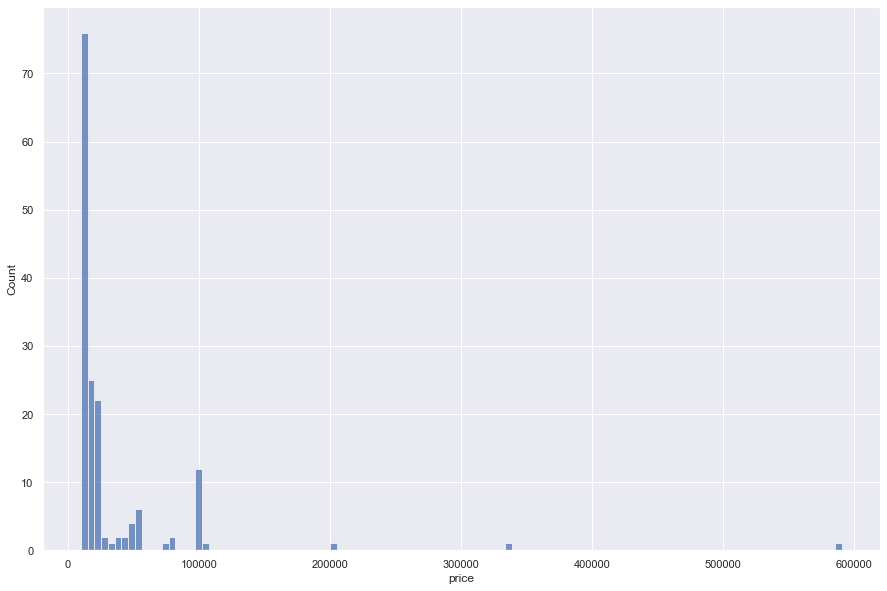

In [149]:
sns.histplot(data = df_subset[df_subset['price'] >= 10000], x = 'price')

In [150]:
df_subset[df_subset['price'] >= 45000].head()

,id,listing_url,last_scraped,source,name,description,host_total_listings_count,host_id,host_about,host_response_time,...,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,zone
1435,2332585,https://www.airbnb.com/rooms/2332585,2022-09-22,city scrape,"Confortable, Well Placed, Nice View","Comfortable apartment, well located, with a wo...",1.0,11913750,"Brasileiro, habitante do Rio de Janeiro, profe...",NaN,...,Entire home/apt,4,1.0,1.0,2.0,"[Air conditioning, Essentials, Washer, Shampoo...",50000.0,50,1125,Central
1725,2677829,https://www.airbnb.com/rooms/2677829,2022-09-22,city scrape,Apart Arpoador Well located- Best RJ Beaches,"It is a cozy apartment, very well located a fe...",5.0,7673499,"Jornalista, produtora de audiovisual, apaixona...",a few days or more,...,Entire home/apt,6,1.0,2.0,3.0,"[Iron, Essentials, Washer, Microwave, Kitchen,...",50000.0,2,1125,Sul
3457,7695145,https://www.airbnb.com/rooms/7695145,2022-09-22,city scrape,q,xxxxx,1.0,40415426,NaN,a few days or more,...,Private room,2,2.0,1.0,2.0,"[Washer, Wifi, Long term stays allowed, Kitche...",100000.0,1,1125,Norte
3504,8596751,https://www.airbnb.com/rooms/8596751,2022-09-21,city scrape,Tudo Super Bacana pra Voltar Sempre,Quarto confortável e privativo. Os melhores so...,1.0,38555079,NaN,within a few hours,...,Private room,1,1.0,1.0,1.0,"[Cable TV, Heating, Air conditioning, Hangers,...",74111.0,2,4,Oeste
4103,9952483,https://www.airbnb.com/rooms/9952483,2022-09-22,city scrape,"Suite Balcony, breezy, sunny morning.",I love the view to the green. Transport at the...,5.0,51144125,"Sou uma pessoa feliz. \r\n Gosto de musica , f...",a few days or more,...,Private room,2,1.0,1.0,1.0,"[Hangers, Dedicated workspace, Lock on bedroom...",335103.0,1,15,Oeste


Looking into the data, it looks like some listings are effectively high-end listings. That is not the case for all listings.\
Let's see how the max looks like if we propose quantile cuts to the data.

In [151]:
percentile_ranges = [.75,.8,.85,.9,.95,.99,.995]

percentile_values = np.quantile(df_subset['price'], percentile_ranges)

percentile_dict = {k:v for k, v in zip(percentile_ranges, percentile_values)}

In [152]:
percentile_dict

{0.75: 600.0,
 0.8: 750.0,
 0.85: 969.0,
 0.9: 1289.0,
 0.95: 2060.75,
 0.99: 7000.0,
 0.995: 10311.0}

If we cut as little as 0.5% of the data on the top end, we might land on a more feasible region for price distribution without having to worry about the extreme prices.

In [153]:
df_subset[df_subset['price']<=percentile_dict[0.995]]['price'].describe()

count    26236.000000
mean       596.347462
std        941.909566
min          0.000000
25%        182.000000
50%        300.000000
75%        600.000000
max      10311.000000
Name: price, dtype: float64

## 0 Values

In [154]:
df_subset[df_subset['price'] == 0]

,id,listing_url,last_scraped,source,name,description,host_total_listings_count,host_id,host_about,host_response_time,...,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,zone
14541,43036115,https://www.airbnb.com/rooms/43036115,2022-09-22,city scrape,Rio Design Hotel,NaN,2.0,311180109,NaN,NaN,...,Hotel room,0,NaN,NaN,NaN,"[House bikes, Smoke alarm, Self-parking R$50/s...",0.0,1,365,Sul
14650,43148322,https://www.airbnb.com/rooms/43148322,2022-09-21,city scrape,Américas Barra Hotel & Eventos,NaN,8.0,315032561,Localizado na Avenida das Américas entre a Bar...,NaN,...,Hotel room,0,NaN,NaN,NaN,"[Smoke alarm, Self-parking R$25/day, Rooftop p...",0.0,1,365,Oeste
14651,43148433,https://www.airbnb.com/rooms/43148433,2022-09-22,city scrape,Américas Copacabana Hotel,NaN,9.0,318396893,NaN,NaN,...,Hotel room,0,NaN,NaN,NaN,"[Heating, Self-parking R$35/day, Smoke alarm, ...",0.0,2,365,Sul
14696,43247506,https://www.airbnb.com/rooms/43247506,2022-09-22,city scrape,Americas Granada Hotel,NaN,2.0,310461308,NaN,NaN,...,Hotel room,0,NaN,NaN,NaN,"[Toiletries, Air conditioning, Fire extinguish...",0.0,1,365,Central
14744,43309227,https://www.airbnb.com/rooms/43309227,2022-09-22,city scrape,Augusto's Riocopa Hotel,NaN,4.0,312899567,NaN,NaN,...,Hotel room,0,NaN,NaN,NaN,"[Self-parking R$40/stay, Smoke alarm, 32\ TV, ...",0.0,1,365,Sul
15309,45636785,https://www.airbnb.com/rooms/45636785,2022-09-22,city scrape,Selina Copacabana,NaN,11.0,369708259,NaN,within an hour,...,Hotel room,0,NaN,NaN,NaN,"[Toiletries, Air conditioning, Fire extinguish...",0.0,1,28,Sul


They look like mistakes. When checking the listing's URL, they have a price.\
For simplicity these will be removed

In [155]:
df_subset = df_subset[df_subset['price'] > 0].copy()

## Plotting the resulting distribution

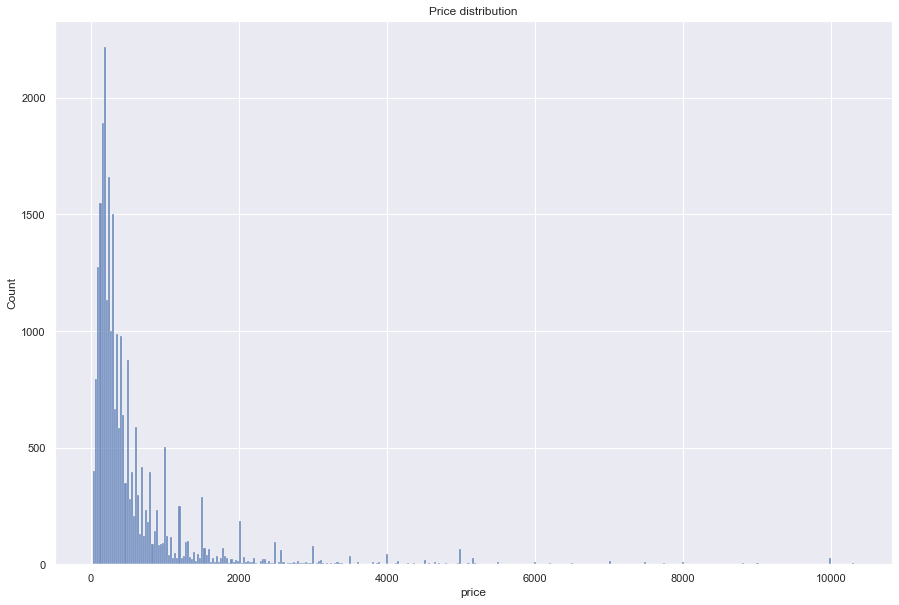

In [156]:
fig, ax = plt.subplots()

sns.histplot(data = df_subset[df_subset['price'] <= percentile_dict[0.995]], x = 'price', ax = ax)

ax.set_title('Price distribution')

plt.show()

Price is a right-skewed distribution.\
This is expected, since the amount of goods (listings in this case) tend to be higher towards lower price ranges since these ranges are more affordable.

It's clearly not normal, but it could be lognormal. 

In [157]:
# Filtering the data to remove extreme values
df_subset = df_subset[df_subset['price'] <= percentile_dict[0.995]].copy()

# Is market concentration related to price?

Does owning multiple listings affect how prices behave somehow? 

We can look at it in two ways from the data we have at hand:
- We can look by zones and neighbourhoods
- We correlate that directly on the data looking to the host_listings and price columns


In [158]:
def get_geo_host_aggregates(data = df_subset, group_col = None):

    # Aggregating data
    aggregate = data.groupby(group_col)\
                        .agg({'host_id':'nunique','id':'count','price':['mean','std','median']})

    # Removing multiindex
    aggregate.columns = [f'{x}_{y}' for x, y in aggregate.columns]

    # Fetching the zones for plot
    aggregate.reset_index(drop = False, inplace = True)

    # Getting avg listings by host - Market Concentration metric
    aggregate['listings_by_host'] = aggregate['id_count'] / aggregate['host_id_nunique']

    return aggregate

## Geographical Lens
Looking into market concentration geographically

### Zones

In [160]:
aggs_by_zone = get_geo_host_aggregates(group_col = 'zone')

In [161]:
aggs_by_zone

,zone,host_id_nunique,id_count,price_mean,price_std,price_median,listings_by_host
0,Central,1432,1950,387.934872,907.916861,174.5,1.361732
1,Norte,1158,1473,419.211813,751.399089,189.0,1.272021
2,Oeste,5159,7237,785.120077,1150.947655,400.0,1.402791
3,Sul,9418,15570,551.694669,834.052347,300.0,1.653217


There are a lot more listings on the south zone of the city.\
This is expected behaviour, since it's the predominant zone for tourist attractions

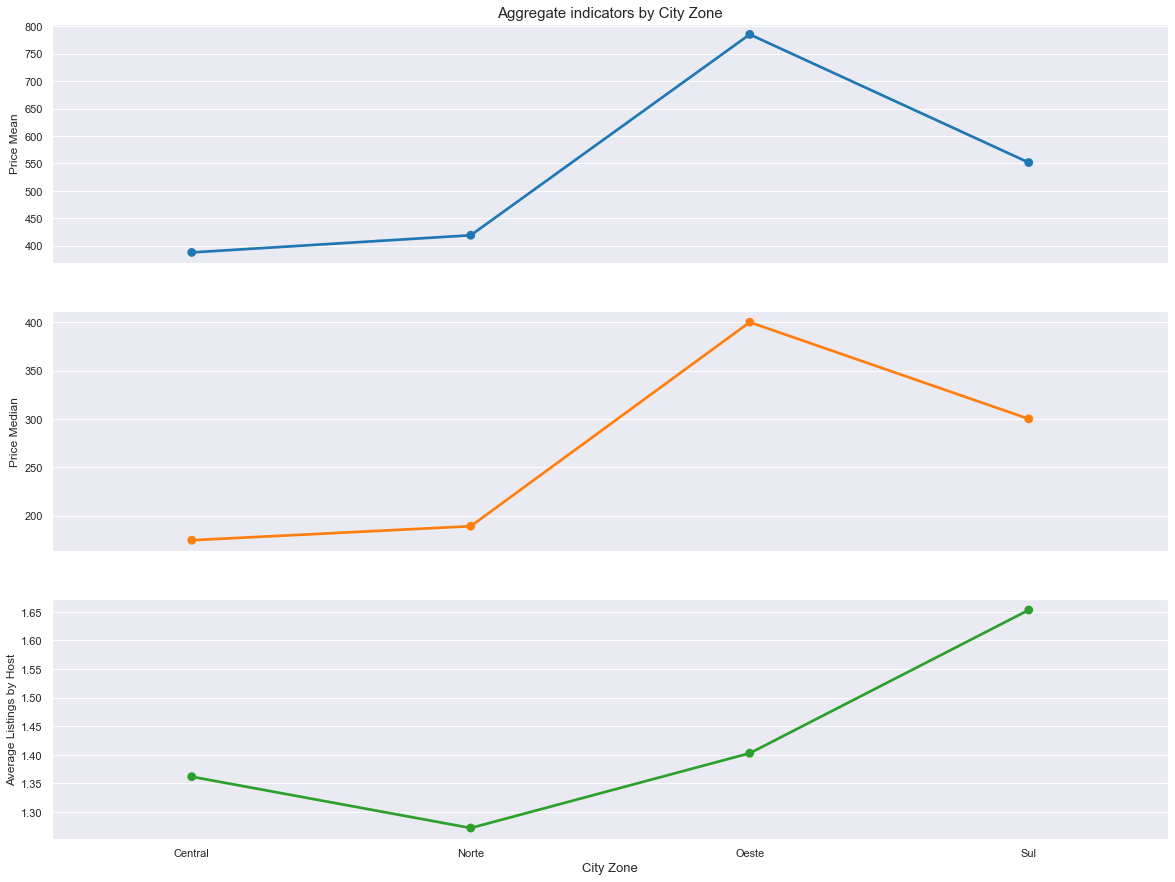

In [162]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize = (20,15),sharex = True)

sns.pointplot(data = aggs_by_zone, x = 'zone', y = 'price_mean', ax = ax1, color='tab:blue')

ax1.set_ylabel('Price Mean')

ax1.set_xlabel('')

ax1.set_title('Aggregate indicators by City Zone', fontdict = {'fontsize':15})

sns.pointplot(data = aggs_by_zone, x = 'zone', y = 'price_median', ax = ax2, color = 'tab:orange')

ax2.set_ylabel('Price Median')

ax2.set_xlabel('')

sns.pointplot(data = aggs_by_zone, x = 'zone', y = 'listings_by_host', ax = ax3, color = 'tab:green')

ax3.set_ylabel('Average Listings by Host')

ax3.set_xlabel('City Zone', fontdict={'fontsize':13})

plt.show()

Looking at the data through the Zoning lens, it doesn't looks like Zones that have more average listings by host (i.e. more concentrated markets) necessairly will result in higher prices

### Neighborhoods

In [163]:
aggs_by_neighbourhoods = get_geo_host_aggregates(group_col = ['neighbourhood_cleansed','zone'])

In [164]:
# Getting only neighbourhoods with a good sample size
aggs_by_neighbourhoods = aggs_by_neighbourhoods[aggs_by_neighbourhoods['id_count'] >= 30]

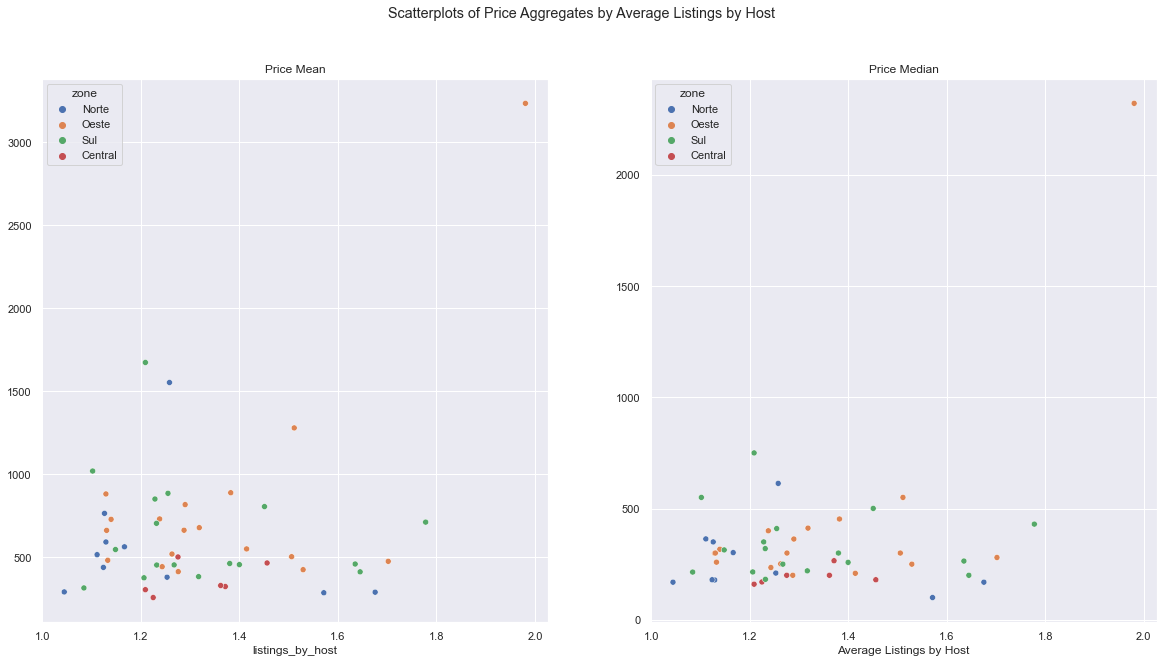

In [165]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10),sharex = True)

sns.scatterplot(data = aggs_by_neighbourhoods, x = 'listings_by_host', y = 'price_mean',hue = 'zone',ax = ax1)

ax1.set_title('Price Mean')

ax1.set_ylabel('')

ax2.set_xlabel('Average Listings by Host')

sns.scatterplot(data = aggs_by_neighbourhoods, x = 'listings_by_host', y = 'price_median',hue = 'zone',ax = ax2)

ax2.set_title('Price Median')

ax2.set_ylabel('')

ax2.set_xlabel('Average Listings by Host')

plt.suptitle('Scatterplots of Price Aggregates by Average Listings by Host')

plt.show()

Even breaking down at the neighbourhood level, no evident pattern arises

## Directly from Data

In [190]:
agg_host = df_subset.groupby('host_id').agg({'host_total_listings_count':'unique', 'price':'mean'})

# Getting rid of Arrays
agg_host = agg_host.explode('host_total_listings_count')

# Type fix
agg_host['host_total_listings_count'] = agg_host['host_total_listings_count'].astype(float)

# We are only interested in hosts with more than 1 listing
agg_host = agg_host[agg_host['host_total_listings_count'] > 1]

In [192]:
print('Pearson Correlation')
display(agg_host.corr('pearson'))

print('Spearman Correlation')
display(agg_host.corr('spearman'))

Pearson Correlation


,host_total_listings_count,price
host_total_listings_count,1.00000,0.03605
price,0.03605,1.00000


Spearman Correlation


,host_total_listings_count,price
host_total_listings_count,1.000000,0.002055
price,0.002055,1.000000


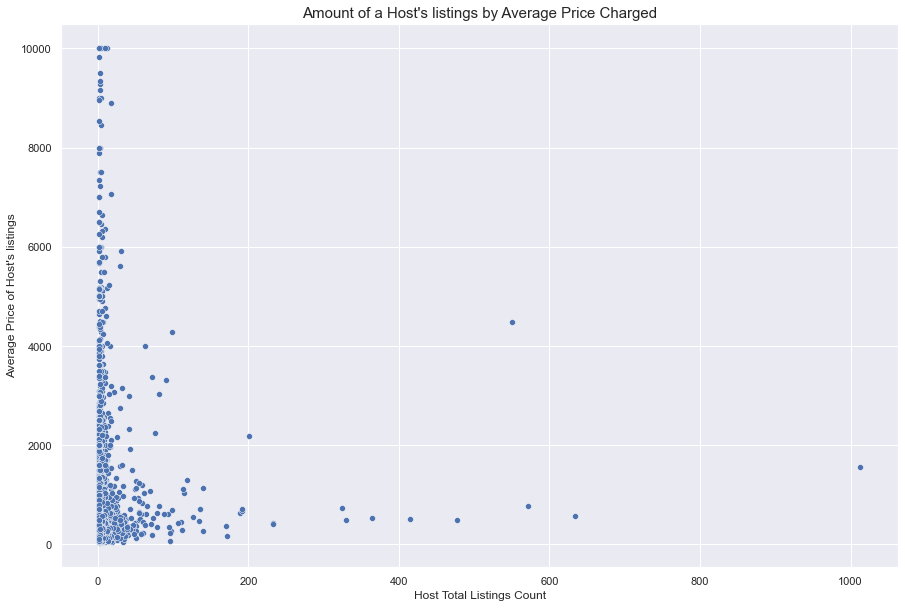

In [199]:
sns.scatterplot(data = agg_host, x = 'host_total_listings_count', y = 'price')

plt.xlabel('Host Total Listings Count')

plt.ylabel("Average Price of Host's listings")

plt.title("Amount of a Host's listings by Average Price Charged", fontdict={'fontsize':15})

plt.show()

Even by trying to correlate the data directly, there seems to be no evidence that links the number of listings from a user to the price charged by that host.

## Amenities analysis

- What are the Amenities that might have the biggest price differences

Let's create a quick corpus for our data and see if we can keep only some key amenities or come up with other fixes.\
I'm specially interested in the Wifi amenity that contains internet speed. Wifi available or not should be counted regardless of speed. This, of course, excluding specific cases such as well-equipped, remote-work ready AirBnBs

In [31]:
amenities_corpus = df_subset['amenities'].explode()

In [32]:
print('Unique Amenities: ',amenities_corpus.nunique())

Unique Amenities:  3260


In [33]:
# Looking specifically into wifi
len(amenities_corpus[amenities_corpus.str.contains('wifi', case = False)].unique())

401

In [34]:
# Samples
amenities_corpus[amenities_corpus.str.contains('wifi', case = False)].unique()[0:10]

array(['Wifi', 'Wifi 30 Mbps', 'Pocket wifi', 'Wifi 28 Mbps',
       'Fast wifi 101 Mbps', 'Fast wifi 663 Mbps', 'Fast wifi 55 Mbps',
       'Fast wifi 157 Mbps', 'Fast wifi 66 Mbps', 'Fast wifi 542 Mbps'],
      dtype=object)

There are a lot of possible entries for wifi, we'll replace them all for simplicity.\
Will do it in two categories: Fast and Regular Wifi

In [35]:
reg_wifi_pat = r'(?<!Fast\s)wifi'

fast_wifi_pat = r'(?<=Fast\s)wifi'

In [36]:
reg_wifi_repl_str = '|'.join(amenities_corpus[amenities_corpus.str.contains(reg_wifi_pat, case = False)].unique())

fast_wifi_repl_str = '|'.join(amenities_corpus[amenities_corpus.str.contains(fast_wifi_pat, case = False)].unique())

In [37]:
amenities_corpus = amenities_corpus.str.replace(reg_wifi_repl_str,'Wifi', regex = True)\
                                    .str.replace(fast_wifi_repl_str,'Fast Wifi', regex = True)

In [38]:
print('Unique Amenities: ',amenities_corpus.nunique())

Unique Amenities:  2910


### Obtaining the most usual amenities

The most frequent amenities are those that are present in a big part of the listings. The total count of an amenity means the amount of appearances of that amenity on listings

In [39]:
amenities_pareto = amenities_corpus.value_counts().to_frame()

In [40]:
amenities_pareto.rename(columns = {'amenities':'listings_count'}, inplace = True)

In [41]:
# Getting proportion of amenities in listings
amenities_pareto['listings_proportion'] = amenities_pareto['listings_count'] / df_subset.shape[0]

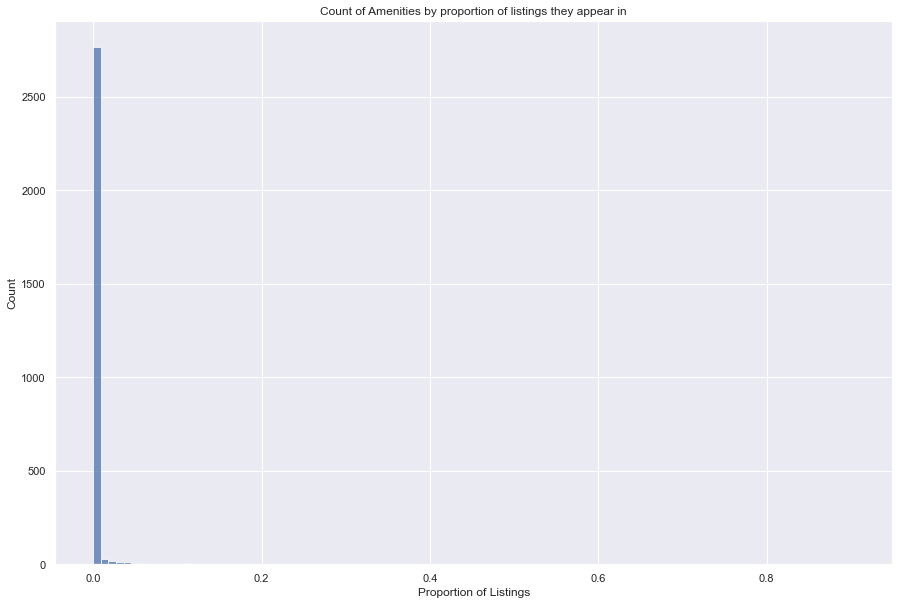

In [42]:
sns.histplot(data = amenities_pareto, x = 'listings_proportion', bins = 100)

plt.title('Count of Amenities by proportion of listings they appear in')

plt.xlabel('Proportion of Listings')

plt.show()

In [43]:
for proportion in np.arange(0,1.1,.1):

    print(f'Amount of amenities that occur in at least {proportion:.2%} of all listings:',amenities_pareto[amenities_pareto['listings_proportion'] >= proportion].shape[0])
    

Amount of amenities that occur in at least 0.00% of all listings: 2910
Amount of amenities that occur in at least 10.00% of all listings: 56
Amount of amenities that occur in at least 20.00% of all listings: 34
Amount of amenities that occur in at least 30.00% of all listings: 23
Amount of amenities that occur in at least 40.00% of all listings: 18
Amount of amenities that occur in at least 50.00% of all listings: 13
Amount of amenities that occur in at least 60.00% of all listings: 9
Amount of amenities that occur in at least 70.00% of all listings: 4
Amount of amenities that occur in at least 80.00% of all listings: 3
Amount of amenities that occur in at least 90.00% of all listings: 2
Amount of amenities that occur in at least 100.00% of all listings: 0


1. There might be a lot of unique values because of an open format of the field. 
2. Of all the possible amenities, only 13 appear on more than half of the listings. If we make a cut as small as 10% we can already indetify a relevant subset of amenities

### Analyzing the top amenities

Making the 10% cut, we are going to evaluate the price difference for the presence or absence of the amenities

In [93]:
list_key_amenities = amenities_pareto[amenities_pareto['listings_proportion'] >= 0.5].index.values

In [94]:
df_amenities = df_subset[['id','price','amenities']].copy()

In [95]:
for amenity in list_key_amenities:

    amen_func = lambda am_list: amenity in am_list

    df_amenities[f'am_{amenity}'] = df_amenities['amenities'].apply(amen_func)

In [96]:
df_amenities.head()

,id,price,amenities,am_Wifi,am_Kitchen,am_Long term stays allowed,am_Essentials,am_Hangers,am_Iron,am_Hot water,am_Air conditioning,am_Dishes and silverware,am_Elevator,am_Cooking basics,am_Refrigerator,am_Bed linens
0,53344884,3500.0,"[Air conditioning, Washer, Security cameras on...",True,True,True,False,False,False,False,True,False,False,False,False,False
1,7801456,5000.0,"[Cable TV, Air conditioning, Fire extinguisher...",True,True,True,True,False,False,True,True,False,True,False,False,False
2,14333905,681.0,"[Cable TV, Air conditioning, Hair dryer, Iron,...",True,True,True,False,False,True,False,True,False,False,False,False,False
3,44708736,8999.0,"[Single level home, Wifi 30 Mbps, Dedicated wo...",False,True,False,True,True,False,True,False,True,False,True,False,True
4,35351763,500.0,"[Air conditioning, First aid kit, Iron, Essent...",True,True,False,True,False,True,False,True,False,False,False,False,False


In [97]:
am_cols = [col for col in df_amenities.columns if col.startswith('am_')]

In [98]:
dict_am_prices = {}

dict_am_prices['am_Wifi'] = df_amenities.groupby('am_Wifi')['price'].mean().to_dict()

In [99]:
dict_am_prices

{'am_Wifi': {False: 773.156005788712, True: 783.938763039588}}

In [100]:
re.sub('am_','','am_Wifi')

'Wifi'

In [101]:
dict_am_prices = {}

for col in am_cols:

    name = re.sub('am_','',col)

    dict_am_prices[name] = df_amenities.groupby(col)['price'].agg(['mean','count'])\
                                                                .to_dict()


In [102]:
dict_am_prices

{'Wifi': {'mean': {False: 773.156005788712, True: 783.938763039588},
  'count': {False: 3455, True: 22911}},
 'Kitchen': {'mean': {False: 904.3426707597852, True: 769.164898989899},
  'count': {False: 2606, True: 23760}},
 'Long term stays allowed': {'mean': {False: 950.6460481099656,
   True: 759.294496006907},
  'count': {False: 3201, True: 23165}},
 'Essentials': {'mean': {False: 1197.444245773732, True: 656.2480459087761},
  'count': {False: 6152, True: 20214}},
 'Hangers': {'mean': {False: 921.8906502749919, True: 706.9199672380506},
  'count': {False: 9273, True: 17093}},
 'Iron': {'mean': {False: 967.8883622428399, True: 670.7899088145897},
  'count': {False: 9916, True: 16450}},
 'Hot water': {'mean': {False: 1149.7749551703528, True: 556.7512248897599},
  'count': {False: 10038, True: 16328}},
 'Air conditioning': {'mean': {False: 560.839902200489,
   True: 922.9593581562481},
  'count': {False: 10225, True: 16141}},
 'Dishes and silverware': {'mean': {False: 1127.556726173056

## 